In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np


#variables declaration
trading_fees = 2 #as a percentage
minimum_earned_per_trade = 1 #minimum amount of money to earn per trade
minimum_volume_per_trade = 5 #minimum amount of volume required for each trade

#dataset location declaration
main_data_location = './data/BTCPrices.xlsx'
gemini_price_sheet = 'Gemini'
reuters_price_sheet = 'Reuters'

buy_gemini_signal = 0 #signal to buy Gemini and sell in Reuters
buy_reuters_signal = 1 #signal to buy in Reuters and sell in Gemini
trade_signal_positive = 1 #signal to go ahead with the trade
trade_signal_negative = 0 #signal to not continue with the trade

#variables for data cleaning and formatting
gemini_index_title = 'Date (EST)'
reuters_index_title = 'Time'

gemini_price_title = 'Open'
reuters_price_title = 'Open'
trade_volume_title = 'Volume'

#variables for plots
figure_length = 8
figure_breadth = 4
figure_dpi = 200
gemini_legend_title = "Gemini BTC"
reuters_legend_title = "Reuters BTC"
figure_title = 'BTC Opening Prices'
figure_save_name = 'priceComparison.png'

#variable for analysis, where CT stands for column title
ct_gemini_open = "Gemini_Open"
ct_reuters_open = "Reuters_Open"
ct_trade_volume = "Trade_Volume"
ct_absolute_difference = "Absolute_Difference"
ct_total_tax = "Total_Tax"
ct_buy_gemini_sell_reuters = "BuyGemSellReuOrder"
ct_nett_money_earned = "Money_Earned"
ct_execute_trade = "Execute"


In [2]:
trading_fees = trading_fees/100 #converting into percentages

#reading in datasets
df_Gemini = pd.read_excel(main_data_location, sheet_name = gemini_price_sheet, na_values = None)
df_Reuters = pd.read_excel(main_data_location, sheet_name = reuters_price_sheet)

df_Gemini = df_Gemini.set_index(gemini_index_title)
df_Reuters = df_Reuters.set_index(reuters_index_title)

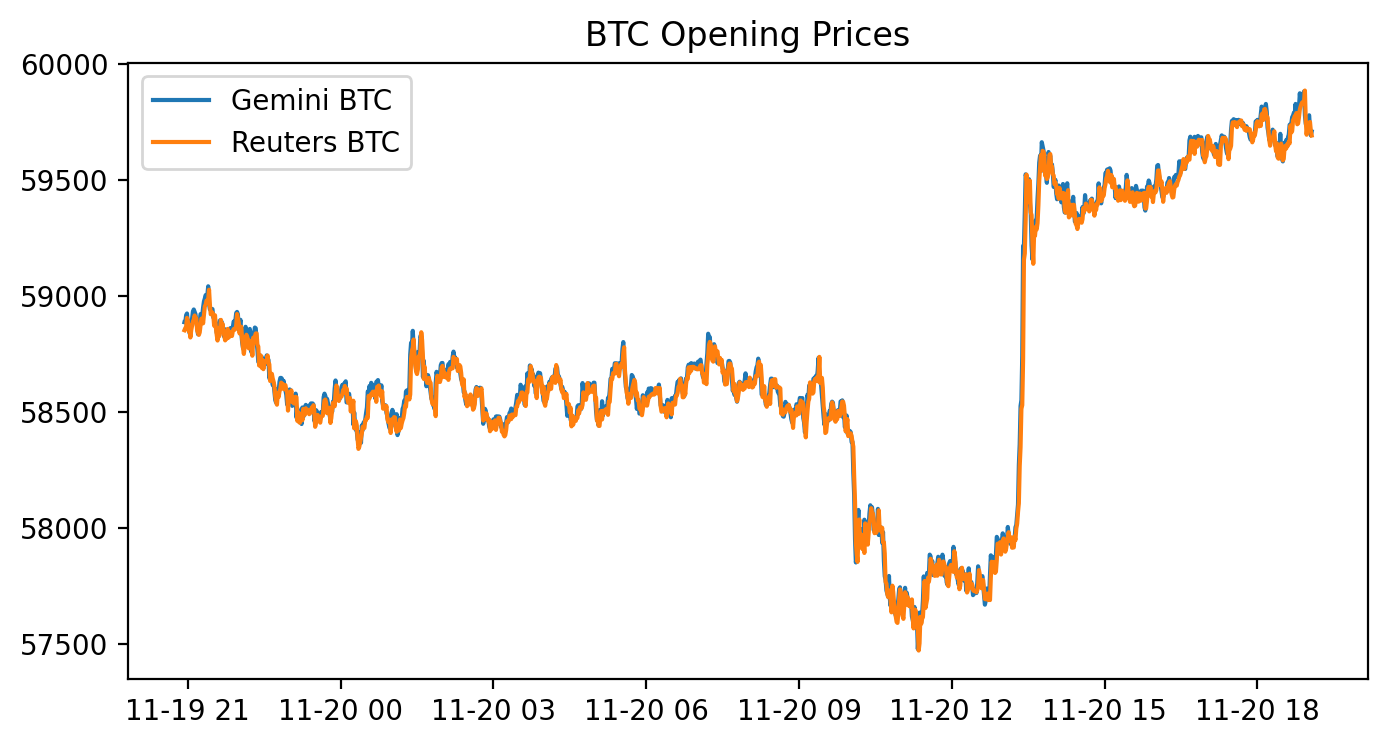

In [3]:
#plotting graphs to analyze
price_Gemini = df_Gemini[gemini_price_title]
price_Reuters = df_Reuters[reuters_price_title]
trade_volume = df_Gemini[trade_volume_title]


figure(figsize=(figure_length, figure_breadth), dpi=figure_dpi)


plt.plot(price_Gemini, label = gemini_legend_title)
plt.plot(price_Reuters, label = reuters_legend_title)
plt.title(figure_title)
plt.legend()
plt.savefig(figure_save_name)


In [4]:
#calculating theoretical max earnings
theoretical_max = sum(abs(price_Gemini - price_Reuters) * trade_volume)
print(theoretical_max)

42357.951989773916


In [5]:
#taking fees into account. For this analysis, we are assuming a 2% fee on both the buy and sell side
df_Combined = pd.concat([price_Gemini,
                     price_Reuters,
                     trade_volume,
                     abs(price_Gemini - price_Reuters),
                     trading_fees * (price_Gemini + price_Reuters)], axis = 1) 
df_Combined.columns = [ct_gemini_open, 
                       ct_reuters_open, 
                       ct_trade_volume, 
                       ct_absolute_difference, 
                       ct_total_tax]

In [6]:
#include the trade signals. 
temp_frame = pd.DataFrame(np.where(df_Combined[ct_gemini_open] > df_Combined[ct_reuters_open], 
                                   buy_gemini_signal, 
                                   buy_reuters_signal))
temp_frame.index = df_Combined.index
temp_frame.columns = [ct_buy_gemini_sell_reuters]
df_Combined = pd.concat([df_Combined, temp_frame], axis= 1)

In [7]:
#include the amount of money earned post commission fees
temp_frame = pd.DataFrame(df_Combined[ct_absolute_difference] * df_Combined[ct_trade_volume] 
                          - df_Combined[ct_total_tax])
temp_frame.index = df_Combined.index
temp_frame.columns = [ct_nett_money_earned]
df_Combined = pd.concat([df_Combined, temp_frame], axis = 1)

In [8]:
#include the trade signals. The trade will only happen if we earn money
#0 means no trade
#1 means we trade

temp_selection = np.logical_and((df_Combined[ct_nett_money_earned] > minimum_earned_per_trade),  
                                (df_Combined[ct_trade_volume] > minimum_volume_per_trade))

temp_frame = pd.DataFrame(np.where(temp_selection,
                                   trade_signal_positive,
                                   trade_signal_negative))
temp_frame.index = df_Combined.index
temp_frame.columns = [ct_execute_trade]
df_Combined = pd.concat([df_Combined, temp_frame], axis= 1)


In [9]:
df_Combined

,Gemini_Open,Reuters_Open,Trade_Volume,Absolute_Difference,Total_Tax,BuyGemSellReuOrder,Money_Earned,Execute
2021-11-20 19:04:00,59710.00,59692.80,4.922584,17.20,2388.0560,0,-2303.387556,0
2021-11-20 19:03:00,59693.05,59711.00,0.798032,17.95,2388.0810,1,-2373.756317,0
2021-11-20 19:02:00,59721.66,59751.04,1.134838,29.38,2389.4540,1,-2356.112461,0
2021-11-20 19:01:00,59779.96,59748.71,0.511603,31.25,2390.5734,0,-2374.585799,0
2021-11-20 19:00:00,59770.47,59731.89,0.144430,38.58,2390.0472,0,-2384.475099,0
...,...,...,...,...,...,...,...,...
2021-11-19 21:00:00,58883.87,58893.40,1.878430,9.53,2355.5454,1,-2337.643959,0
2021-11-19 20:59:00,58924.65,58905.70,0.938543,18.95,2356.6070,0,-2338.821609,0
2021-11-19 20:58:00,58916.85,58867.50,0.265009,49.35,2355.6870,0,-2342.608803,0
2021-11-19 20:57:00,58885.86,58861.00,0.182373,24.86,2354.9372,0,-2350.403406,0


In [10]:
#check which orders are fulfilled
orders_fulfilled = df_Combined.loc[df_Combined[ct_execute_trade] == trade_signal_positive]
print(orders_fulfilled)

                     Gemini_Open  Reuters_Open  Trade_Volume  \
2021-11-20 13:24:00     59216.09      58725.23     27.313468   
2021-11-20 13:23:00     58740.88      58529.10     27.464903   

                     Absolute_Difference  Total_Tax  BuyGemSellReuOrder  \
2021-11-20 13:24:00               490.86  2358.8264                   0   
2021-11-20 13:23:00               211.78  2345.3996                   0   

                     Money_Earned  Execute  
2021-11-20 13:24:00  11048.262512        1  
2021-11-20 13:23:00   3471.117610        1  


In [11]:
#Possible further improvements

#Perhaps it would be possible to calculate the success rate of the trade, 
#and factor that into the estimated overall profit.

#I am open to any further suggestions on how to improve this arbitrage tool